# Preprocess data

In [1]:
import csv
import cv2
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sklearn
import random

from sklearn.model_selection import train_test_split

In [2]:
def load_zipped_pickle(file_path):
    with gzip.open(file_path, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def data_generator(samples, shape, batch_size=32):
    num_samples = len(samples)
    rows, cols, ch = shape
    
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            X = np.zeros(shape=(batch_size, rows, cols, ch), dtype=np.float32)
            y = np.zeros(shape=(batch_size), dtype=np.float32)
            for i, sample in enumerate(batch_samples):
                # read driving log data
                img_path = '../' +  sample[0]
                angle = float(sample[1])
                
                # get image
                img = load_zipped_pickle(img_path)
                
                # load images and steering angles
                X[i] = img
                y[i] = angle

            yield sklearn.utils.shuffle(X, y)

In [4]:
samples = []
with open('../data/interim/center/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
samples = samples[1:-1]

In [5]:
samples = random.sample(samples, 10000)

x shape = (32, 80, 320, 3)
y shape = (32,)
[ 0.          0.00884002 -0.2686331  -0.00884002  0.15744521  0.          0.1900606
  0.          0.37570101  0.0663003   0.          0.09724023  0.02348577
  0.3138209  -0.08840021 -0.01768004  0.          0.2431007   0.
 -0.05975719  0.01768004  0.06188015  0.          0.          0.340341
 -0.59670162 -0.50388122  0.2431007  -0.02652006 -0.02652006  0.07514032
  0.14787669]


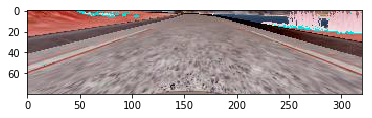

In [6]:
test_generator = data_generator(samples[0:100], shape=(80, 320, 3), batch_size=32)

for i in range(1):
    X_batch, y_batch = next(test_generator)
    print('x shape = {}\ny shape = {}'.format(X_batch.shape, y_batch.shape))
    print(y_batch)
    plt.imshow(X_batch[0])
    plt.show()

# Keras modelling

In [7]:
from keras.models import Sequential
from keras.layers import Lambda, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
# hyper parameters
epochs = 10
batch_size = 6

In [9]:
# set known image attributes
shape = (80, 320, 3)

# set train and validate sets
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# set generator functions
train_generator = data_generator(train_samples, 
                                 shape=shape, 
                                 batch_size=batch_size)
validation_generator = data_generator(validation_samples, 
                                      shape=shape,
                                      batch_size=batch_size)

In [10]:
# https://arxiv.org/pdf/1604.07316.pdf
# model architecture
model = Sequential()

# normalisation
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=shape))

# Convolution2D(filters, kernel, stride)
model.add(Convolution2D(6, 5, 5, activation='elu'))
model.add(MaxPooling2D())
model.add(Convolution2D(12, 5, 5, activation='elu'))
model.add(MaxPooling2D())
model.add(Convolution2D(24, 3, 3, activation='elu'))
model.add(MaxPooling2D())
model.add(Convolution2D(36, 3, 3, activation='elu'))
model.add(MaxPooling2D())
model.add(Convolution2D(128, 1, 1, activation='elu'))
model.add(MaxPooling2D())
# model.add(Convolution2D(24, 5, 2, activation='elu'))
# model.add(MaxPooling2D())
# model.add(Convolution2D(36, 5, 2, activation='elu'))
# model.add(MaxPooling2D())
# model.add(Convolution2D(48, 5, 2, activation='elu'))
# model.add(MaxPooling2D())
# model.add(Convolution2D(64, 3, 3, activation='elu'))
# model.add(MaxPooling2D())

# flatten
model.add(Flatten())

# fully connected
model.add(Dense(100, activation='elu'))
model.add(Dense(10, activation='elu'))

# output
model.add(Dense(1))

In [11]:
model.compile(optimizer=Adam(lr=1e-04), loss='mean_squared_error')

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=len(train_samples), 
                                     validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples), 
                                     nb_epoch=epochs,
                                     verbose=1)

Epoch 1/10
7998/8000 [============================>.] - ETA: 0s - loss: 0.0239

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


8004/8000 [==============================] - 30s - loss: 0.0239 - val_loss: 0.0221
Epoch 2/10
8004/8000 [==============================] - 28s - loss: 0.0176 - val_loss: 0.0196
Epoch 3/10
8004/8000 [==============================] - 29s - loss: 0.0154 - val_loss: 0.0180
Epoch 4/10
8004/8000 [==============================] - 28s - loss: 0.0140 - val_loss: 0.0172
Epoch 5/10
8004/8000 [==============================] - 28s - loss: 0.0129 - val_loss: 0.0164
Epoch 6/10
8004/8000 [==============================] - 28s - loss: 0.0119 - val_loss: 0.0157
Epoch 7/10
8004/8000 [==============================] - 28s - loss: 0.0110 - val_loss: 0.0151
Epoch 8/10
8004/8000 [==============================] - 28s - loss: 0.0103 - val_loss: 0.0147
Epoch 9/10
8004/8000 [==============================] - 28s - loss: 0.0095 - val_loss: 0.0144
Epoch 10/10
8004/8000 [==============================] - 28s - loss: 0.0089 - val_loss: 0.0143


In [15]:
model.save('../model.h5')

In [13]:
# print the keys contained in the history object
print(history_object.history.keys())

dict_keys(['val_loss', 'loss'])


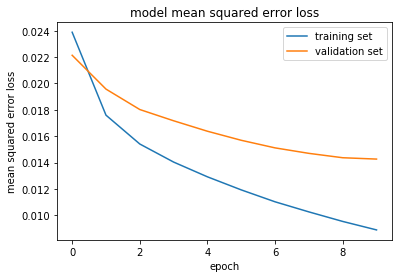

In [14]:
# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()